In [1]:
import torch
import h5py
import os
import numpy as np
from torch import nn as nn
from torch.nn import functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
# import time
# from d2l import torch as d2l
# import random

In [3]:
from d2l import torch as d2l

In [4]:
# get the file name of path
def get_fname(path):
    files = os.listdir(path)
    files.sort()
    return files

In [5]:
data_dir = "../dataset"

In [6]:
files = get_fname(data_dir)

In [7]:
files[0]

'snapshot_000.hdf5'

In [8]:
def get_fpath(path, fname):
    return os.path.join(path, fname)

In [9]:
f5 = h5py.File(get_fpath(data_dir, files[5]))

In [10]:
def get_hdf5_group(hdf5File):
    group = []
    for key in hdf5File:
        group.append(key)
    return group

In [11]:
get_hdf5_group(f5)[0]

'dataset'

In [12]:
data = f5[get_hdf5_group(f5)[0]]

In [14]:
data.shape

(242311, 12)

In [13]:
data[0], data[0].shape

(array([ 1.0000000e+00,  2.9456370e+21,  7.9912119e+00,  1.4510067e+07,
        -1.9743911e+11,  2.4654568e+07, -1.6384232e+08, -3.0284028e+07,
        -1.0712665e+07,  3.7325620e+03,  4.7539352e+04,  2.7685675e+02],
       dtype=float32),
 (12,))

In [15]:
type(data[0])

numpy.ndarray

In [22]:
data[0:4:2].shape

(2, 12)

In [16]:
# This trainshapest we just to use one snapshot just

In [26]:
def data_ratio_select(data, data_len):
    return data[0:2*data_len:2]

In [27]:
data0 = data_ratio_select(data, 5000)

In [28]:
len(data0)

5000

In [30]:
# get train set and validation set from the DATA
def reorg_train_vaild(data, valid_ratio):
    l = len(data)
    # data = random.shuffle(data)
    n = l-int(l*valid_ratio)
    train_data = data[:n]
    valid_data = data[n:]
    return train_data, valid_data

In [31]:
train_data0, valid_data0 = reorg_train_vaild(data0, 0.1)

In [32]:
len(train_data0), len(valid_data0)

(4500, 500)

In [33]:
# select the data for test
def recorg_test(data, line, test_len):
    return data[line:2*test_len:2]

In [47]:
test_data0 = recorg_test(data, 5000, 7500) 

In [48]:
len(test_data0)

5000

In [50]:
train_data0[0], valid_data0[0], test_data0[0]

(array([ 1.0000000e+00,  2.9456370e+21,  7.9912119e+00,  1.4510067e+07,
        -1.9743911e+11,  2.4654568e+07, -1.6384232e+08, -3.0284028e+07,
        -1.0712665e+07,  3.7325620e+03,  4.7539352e+04,  2.7685675e+02],
       dtype=float32),
 array([ 9.0010000e+03,  2.9456370e+21,  8.8772240e+00,  1.4436648e+07,
        -2.0922996e+11,  2.3938638e+07, -9.6609600e+07,  1.2520814e+08,
        -7.8623115e+06,  7.0589316e+03,  4.8921453e+04,  2.9340857e+02],
       dtype=float32),
 array([ 5.0010000e+03,  2.9456370e+21,  8.8387938e+00,  1.4320035e+07,
        -2.0741880e+11,  2.3968782e+07, -1.2129664e+08,  9.2385632e+07,
         3.5812348e+07,  6.1908716e+03,  4.8613605e+04, -5.4629895e+02],
       dtype=float32))

In [52]:
train_data0.shape, valid_data0.shape, test_data0.shape

((4500, 12), (500, 12), (5000, 12))

In [53]:
# physcial quantity squence is ids mass rho ie pot sl pos*3 vel*3
def chose_input_output_phy_qua(data, phy_qua):
    assert phy_qua == "mass" or phy_qua == "rho" or phy_qua == "ie" or phy_qua == "pot" or phy_qua == "sl" or phy_qua == "pos" or phy_qua == "vel"
    if phy_qua == "mass":
        return data[:, 1]
    if phy_qua == "rho":
        return data[:, 2]
    if phy_qua == "ie":
        return data[:, 3]
    if phy_qua == "pot":
        return data[:, 4]
    if phy_qua == "rho":
        return data[:, 5]
    if phy_qua == "pos":
        return data[:, -6:-3]
    if phy_qua == "vel":
        return data[:, -3:]

In [54]:
train_data0_pos = chose_input_output_phy_qua(train_data0, "pos")
train_data0_pot = chose_input_output_phy_qua(train_data0, "pot")

In [56]:
train_data0_pot = train_data0_pot.reshape(-1, 1)

In [58]:
train_data0_pos.shape, train_data0_pot.shape

((4500, 3), (4500, 1))

In [59]:
valid_data0_pos = chose_input_output_phy_qua(valid_data0, "pos")
valid_data0_pot = chose_input_output_phy_qua(valid_data0, "pot")

In [61]:
valid_data0_pot = valid_data0_pot.reshape(-1, 1)

In [62]:
valid_data0_pos.shape, valid_data0_pot.shape

((500, 3), (500, 1))

In [63]:
test_data0_pos = chose_input_output_phy_qua(test_data0, "pos")
test_data0_pot = chose_input_output_phy_qua(test_data0, "pot").reshape(-1, 1)

In [65]:
test_data0_pos.shape, test_data0_pot.shape

((5000, 3), (5000, 1))

In [67]:
type(train_data0_pos), type(train_data0_pot), type(valid_data0_pos), type(valid_data0_pot), type(test_data0_pos), type(test_data0_pot)

(numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray)

In [68]:
# norm function for numpy
def data_norm(data):
    mean = data.mean(axis=0, keepdims=True)
    std = data.std(axis=0, keepdims=True)
    return (data-mean)/std

In [69]:
train_data0_pos_norm = data_norm(train_data0_pos)
train_data0_pot_norm = data_norm(train_data0_pot)

In [70]:
train_data0_pos_norm.shape, train_data0_pot_norm.shape

((4500, 3), (4500, 1))

In [75]:
train_data0_pos_norm.max(), train_data0_pos_norm.min()

(2.2776084, -2.4029636)

In [76]:
train_data0_pot_norm.max(), train_data0_pot_norm.min()

(1.2922436, -3.0646796)

In [72]:
valid_data0_pos_norm = data_norm(valid_data0_pos)
valid_data0_pot_norm = data_norm(valid_data0_pot)

In [73]:
valid_data0_pos_norm.shape, valid_data0_pot_norm.shape

((500, 3), (500, 1))

In [77]:
valid_data0_pos_norm.max(), valid_data0_pos_norm.min()

(2.8925111, -3.081011)

In [78]:
valid_data0_pot_norm.max(), valid_data0_pot_norm.min()

(1.4805294, -2.1075025)

In [95]:
def data_to_tensor(data):
    return torch.from_numpy(data)

In [96]:
train_data0_pos_norm_t = data_to_tensor(train_data0_pos_norm)
train_data0_pot_norm_t = data_to_tensor(train_data0_pot_norm)
valid_data0_pos_norm_t = data_to_tensor(valid_data0_pos_norm)
valid_data0_pot_norm_t = data_to_tensor(valid_data0_pot_norm)

In [99]:
type(train_data0_pos_norm_t)

torch.Tensor

In [79]:
# train data and valid dat norm, but test data not norm

In [100]:
# defined SPH output Dataset
class SPHDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    def __len__(self):
        return len(self.features)
    def __getitem__(self, item):
        return self.features[item], self.labels[item]

In [102]:
train_ds = SPHDataset(train_data0_pos_norm_t, train_data0_pot_norm_t)

In [103]:
valid_ds = SPHDataset(valid_data0_pos_norm_t, valid_data0_pot_norm_t)

In [106]:
len(train_ds), train_ds[0]

(4500, (tensor([-2.0733, -0.7192, -0.1763]), tensor([1.1876])))

In [109]:
len(valid_ds), valid_ds[0]

(500, (tensor([-0.6166,  2.1580, -0.1072]), tensor([-0.0422])))

In [112]:
batch_size = 32

In [113]:
train_iter = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
valid_iter = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, drop_last=False)

In [114]:
for i, (feature, label) in enumerate(train_iter):
    if(i < 1):
        print("input: ", feature, feature.shape)
        print("output: ", label, label.shape)
    else:
        break

input:  tensor([[ 0.4291, -0.5322, -1.0545],
        [ 0.0546, -0.7237,  0.0615],
        [ 0.7674,  0.7794, -1.2146],
        [-0.1698,  0.2611, -1.2616],
        [ 0.7737, -0.7346,  0.0772],
        [ 0.7008,  0.5556,  0.5237],
        [ 0.1633,  0.6867, -0.2122],
        [ 0.1781, -0.8056,  1.2132],
        [ 0.0364, -1.6967,  0.8878],
        [-0.4488, -0.2128, -1.0695],
        [ 0.3492,  0.8767, -0.2863],
        [-1.6723, -0.1264, -0.4275],
        [-1.0579, -0.6487, -1.3003],
        [-0.0155, -1.0057, -1.6016],
        [ 0.3698, -1.3869,  1.4640],
        [ 0.9725, -1.2917,  1.1890],
        [-0.6013, -0.2950, -0.5777],
        [-2.1241, -0.0764,  0.6538],
        [ 0.5963, -0.3401, -1.5034],
        [-0.1455, -0.8764,  0.2768],
        [ 0.1418, -1.5003, -0.2352],
        [ 1.3968, -1.8795, -0.1447],
        [ 0.3758, -0.9563,  0.0540],
        [-0.3982, -0.4919,  0.6513],
        [-0.3236,  0.1370, -1.7710],
        [ 1.2247, -0.8040, -0.5598],
        [-0.4278, -0.9150, -1.

In [116]:
for i, (feature, label) in enumerate(valid_iter):
    if(i < 1):
        print("input: ", feature, feature.shape)
        print("output: ", label, label.shape)
        # print(label.shape[0])
    else:
        break

input:  tensor([[-0.6166,  2.1580, -0.1072],
        [-0.3373,  2.1922,  0.1708],
        [ 0.4462,  2.1979,  0.3562],
        [-2.2660,  2.1668,  0.5783],
        [-2.4278,  2.1144,  0.6837],
        [-0.6273,  2.1586,  0.7816],
        [-1.7134,  2.1401,  1.0747],
        [-0.1255,  2.1219,  1.2059],
        [-1.3919,  2.2636, -0.9298],
        [ 0.2080,  2.3954, -0.8599],
        [-1.0919,  2.2278, -0.6305],
        [-0.4448,  2.3055, -0.4793],
        [-1.1283,  2.3206, -0.3373],
        [-2.0289,  2.2894, -0.1947],
        [-1.1608,  2.3516,  0.0784],
        [-0.4847,  2.3524,  0.2991],
        [-0.4229,  2.2930,  0.4897],
        [-0.1824,  2.2613,  0.6532],
        [-1.9775,  2.2310,  0.9387],
        [ 0.0699,  2.2512,  1.0638],
        [-1.7957,  2.3503, -0.7543],
        [-0.9623,  2.4634, -0.5896],
        [-2.0350,  2.4631, -0.4314],
        [ 0.4485,  2.3999, -0.2307],
        [ 0.2874,  2.3406, -0.0892],
        [-1.0621,  2.3471,  0.1385],
        [-0.4803,  2.3536,  0.

In [117]:
len(train_iter), len(valid_iter)

(140, 16)

In [118]:
class MyNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(MyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 10)
        # self.fc2 = nn.Linear(10, 12)
        self.fc3 = nn.Linear(10, output_size)
        
    def forward(self, x):
        # return self.fc3(F.tanh(self.fc2(F.tanh(self.fc1(x)))))
        return self.fc3(F.tanh(self.fc1(x)))

In [142]:
def get_net():
    net = MyNetwork(3, 1)
    return net

In [121]:
from d2l import torch as d2l

In [146]:
loss = nn.MSELoss(reduction='none')

def evaluate_loss(data_iter, net, devices):
    l_sum, n = 0.0, 0
    for features, labels in data_iter:
        features, labels = features.to(devices[0]), labels.to(devices[0])
        outputs = net(features)
        l = loss(outputs, labels)
        l_sum += l.sum()
        n += labels.numel()
    return (l_sum / n).to('cpu')

In [162]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,
                              weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
#             l, acc = d2l.train_batch_ch13(net, features, labels,
#                                           loss, trainer, devices)
            l, acc = train_batch(net, features, labels,
                                loss, trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2],
                              None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        scheduler.step()
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

train loss 0.016, train acc 0.371, valid acc 0.000
12476.3 examples/sec on [device(type='cuda', index=0)]


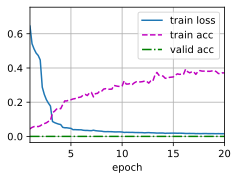

In [163]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 2e-4, 5e-4
lr_period, lr_decay, net = 4, 0.9, get_net()
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

In [149]:
test_data0_pos_t = data_to_tensor(test_data0_pos)
test_data0_pot_t = data_to_tensor(test_data0_pot)

In [152]:
test_data0_pos_t.max(), test_data0_pos_t.min()

(tensor(1.6509e+08), tensor(-1.5471e+08))

In [153]:
test_ds = SPHDataset(test_data0_pos_t, test_data0_pot_t)

In [157]:
len(test_ds), test_ds[0]

(5000,
 (tensor([-1.2130e+08,  9.2386e+07,  3.5812e+07]), tensor([-2.0742e+11])))

In [155]:
test_iter = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, drop_last=False)

In [160]:
def accuracy(y_hat, y, traget):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = d2l.argmax(y_hat, axis=1)
    cmp = (torch.abs(d2l.astype(y_hat, y.dtype) - y) <= target)
    return float(d2l.reduce_sum(d2l.astype(cmp, y.dtype)))

In [161]:
def train_batch(net, X, y, loss, trainer, devices):
    if isinstance(X, list):
        # Required for BERT fine-tuning (to be covered later)
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = accuracy(pred, y, 0.05)
    return train_loss_sum, train_acc_sum

In [164]:
net

MyNetwork(
  (fc1): Linear(in_features=3, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# net = get_net()
# train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,
#       lr_decay)

# target = 0.05

# net.eval()
# with torch.no_grad():
#     for i, (features, labels) in enumerate(test_iter):
#         features, labels = features.to(device), label.to(device)
#         preds = net(features)
#         l = loss(preds, labels)
#         test_loss_sum = l.sum() 
#         test_acc_sum = accuracy(preds, labels, target)
#         print("test loss: ", test_loss_sum / labels.shape[0])
#         print("test acc: ", test_acc_sum / lab)